In [1]:
# Generic imports
from pathlib import Path
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import scipy.stats 

%matplotlib inline

from SAR_retrieval_funcs import cost_function, fwd_model, reproject_data

## Extracting data



In [28]:
chunk = """;301;301;301;301;301;301;301;301;301;301;301;301;508;508;508;508;508;508;508;508;508;508;508;508;542;542;542;542;542;542;542;542;542;542;542;542;319;319;319;319;319;319;319;319;319;319;319;319;515;515;515;515;515;515;515;515;515;515;515;515
;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv;date;sigma_sentinel_vv;sigma_sentinel_vh;theta;relativeorbit;orbitdirection;satellite;LAI;SM;Height;VWC;vh/vv
"""
fields = chunk.split("\n")[0].split(";")[1:]
col_names =[f"{col:s}_{fields[i]:s}" for i, col in enumerate(chunk.split("\n")[1].split(";")[1:])]

df = pd.read_csv("multi.csv", skiprows=2, sep=";", names=col_names)
fields = ["301", "508", "542", "319", "515"]

for field in fields:
    df[f"doy_{field:s}"] = pd.to_datetime(df[f'date_{field:s}']).dt.dayofyear


Text(0.5, 0, 'DoY/2017')

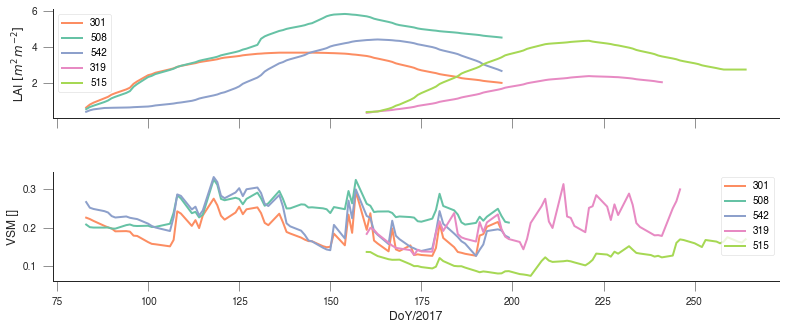

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, 
                        squeeze=True, figsize=(13,5))
l1 = []
l2 = []
for field in fields:
    l1.append(axs[0].plot(df[f"doy_{field:s}"], df[f"LAI_{field:s}"],
               label=field))
    l2.append(axs[1].plot(df[f"doy_{field:s}"], df[f"SM_{field:s}"],
               label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")


axs[0].set_ylabel(r"LAI $[m^2\,m^{-2}]$")
axs[1].set_ylabel("VSM []")
axs[1].set_xlabel("DoY/2017")

/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'DoY/2017')

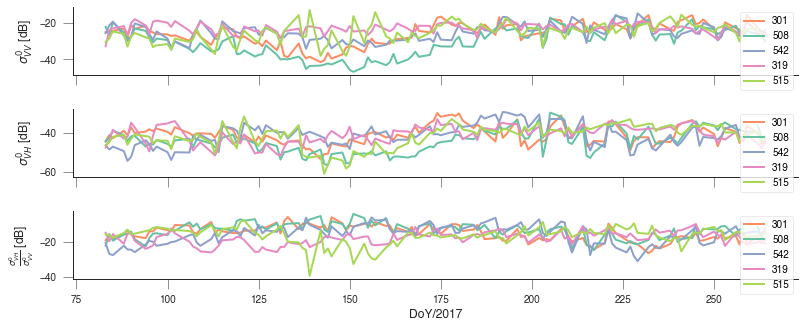

In [44]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, 
                        squeeze=True, figsize=(13,5))
l1 = []
l2 = []
l3 = []
for field in fields:
    l1.append(axs[0].plot(df[f"doy_{field:s}"], 10*np.log(df[f"sigma_sentinel_vv_{field:s}"]),
               label=field))
    l2.append(axs[1].plot(df[f"doy_{field:s}"], 10*np.log(df[f"sigma_sentinel_vh_{field:s}"]),
               label=field))

    l3.append(axs[2].plot(df[f"doy_{field:s}"], 10*np.log(
        df[f"vh/vv_{field:s}"]),
               label=field))

axs[0].legend([l[0] for l in l1], [l[0].get_label() for l in l1], loc="best")
axs[1].legend([l[0] for l in l2], [l[0].get_label() for l in l2], loc="best")
axs[2].legend([l[0] for l in l3], [l[0].get_label() for l in l3], loc="best")


axs[0].set_ylabel(r"$\sigma^{0}_{VV}$ [dB]")
axs[1].set_ylabel(r"$\sigma^{0}_{VH}$ [dB]")
axs[2].set_ylabel(r"$\frac{\sigma^{0}_{VH}}{\sigma^{0}_{VV}}$ [dB]")
axs[2].set_xlabel("DoY/2017")

In [45]:
def invert_field(svv, svh, theta, prior_mean, prior_sd, gamma, s2_lai):
    n_obs = len(svv)
    prior_mean = np.concatenate([[0,]*6, [0.25,]*n_obs, s2_lai])
    prior_sd = np.concatenate([[0,]*6, [0.2,]*n_obs, [0.2,]*n_obs])

    gamma=1000

    xvv = np.array([1, 0.5, sigma_soil_vv_mu ])
    xvh = np.array([1, 0.5, sigma_soil_vh_mu])
    x0 = np.concatenate([xvv, xvh, np.ones(s2_lai.shape[0])*0.2, s2_lai])


    bounds = [[None, None]]*6 + [[0,0.5]]*s2_lai.shape[0] + [[0,8]]*s2_lai.shape[0]

    retval = scipy.optimize.minimize(cost_function, x0, bounds=bounds,jac=True,
                      args=(svh, svv, theta, gamma,prior_mean, prior_sd),
                      tol=1e-10)
    print(f"Initial cost {cost_function(x0,svh, svv, theta,gamma, prior_mean, prior_sd)[0]:g}")
    print(f"Final cost {retval.fun:g}")